In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy
import os
import seaborn as sns

In [2]:
from problem_formulation import get_model_for_problem_formulation
from ema_workbench import ema_logging
from ema_workbench import MultiprocessingEvaluator

from ema_workbench.analysis import parcoords

c:\Users\juliu\Anaconda3\envs\gds24\lib\site-packages\ema_workbench\em_framework\__init__.py:101: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn("ipyparallel not installed - IpyparalleEvaluator not available")


In [3]:
ema_logging.log_to_stderr(ema_logging.INFO)

"""
    Parameters
    ----------
    problem_formulation_id : int {0, ..., 6}
                             problem formulations differ with respect to the objectives
                             0: Total cost, and casualties
                             1: Expected damages, costs, and casualties
                             2: expected damages, dike investment costs, rfr costs, evacuation cost, and casualties
                             3: costs and casualties disaggregated over dike rings, and room for the river and evacuation costs
                             4: Expected damages, dike investment cost and casualties disaggregated over dike rings and room for the river and evacuation costs
                             5: disaggregate over time and space
                             6: Same as 3 but only aggregated for Gelderland, NOTE Expected annual damage only represents Gelderland
                             7: Also added total rfr and total dike_investment

    """
problem_formulation = 7  # Change this to the desired problem formulation ID
dike_model, planning_steps = get_model_for_problem_formulation(problem_formulation)

In [4]:
for unc in dike_model.uncertainties:
    print(repr(unc))

uncertainties = copy.deepcopy(dike_model.uncertainties)
for policy in dike_model.levers:
    print(repr(policy))

levers = copy.deepcopy(dike_model.levers)


CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
IntegerParameter('A.0_ID flood wave shape', 0, 132, resolution=None, default=None, variable_name=['A.0_ID flood wave shape'], pff=False)
RealParameter('A.1_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.1_Bmax'], pff=False)
RealParameter('A.1_pfail', 0, 1, resolution=None, default=None, variable_name=['A.1_pfail'], pff=False)
CategoricalParameter('A.1_Brate', [0, 1, 2])
RealParameter('A.2_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.2_Bmax'], pff=False)
RealParameter('A.2_pfail', 0, 1, resolution=None, default=None, variable_name=['A.2_pfail'], pff=False)
CategoricalParameter('A.2_Brate', [0, 1, 2])
RealParameter('A.3_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.3_Bmax'], pff=False)
RealParameter('A.3_pfail', 0, 1, resolution=None, default=None, variable_name=['A.3_pfai

In [5]:
from ema_workbench import ScalarOutcome, Scenario

# List of outcomes you want to optimize
objectives = ['Expected Annual Damage', 'Expected Number of Deaths']

# # Loop over all outcomes
# for outcome in dike_model.outcomes:
#     if outcome.name in objectives:
#         outcome.kind = ScalarOutcome.MINIMIZE 
#     else:
#         outcome.kind = ScalarOutcome.INFO  # neutral, will be ignored in optimization


for outcome in dike_model.outcomes:
    print(f"{outcome.name}: kind={outcome.kind}")

reference_scenario = Scenario('Reference Scenario', **dict({
    'discount rate 0': 2.5,
    'discount rate 1': 2.5,
    'discount rate 2': 2.5,
    'A.0_ID flood wave shape': 4,
    'A.1_Bmax': 175,
    'A.2_Bmax': 175,
    'A.3_Bmax': 175,
    'A.4_Bmax': 175,
    'A.5_Bmax': 175,
    'A.1_pfail': 0.5,
    'A.2_pfail': 0.5,
    'A.3_pfail': 0.5,
    'A.4_pfail': 0.5,
    'A.5_pfail': 0.5,
    'A.1_Brate': 1.5,
    'A.2_Brate': 1.5,
    'A.3_Brate': 1.5,
    'A.4_Brate': 1.5,
    'A.5_Brate': 1.5
}))



Expected Annual Damage: kind=-1
Dike Investment Costs: kind=-1
RfR Total Costs: kind=-1
Evacuation Costs: kind=-1
Expected Number of Deaths: kind=-1


In [6]:
from ema_workbench.em_framework.optimization import ArchiveLogger, EpsilonProgress
convergence_metrics = [EpsilonProgress()]
# Epsilon values are the ones close to the average value of the outcome, based on exploration and problem formulation.ipynb
#epsilons = [5e7,5e7,5e8,4e3,4]
epsilons = [3e7,3e7,2e8,4e3,2]
with MultiprocessingEvaluator(dike_model) as evaluator:
    results1, convergence = evaluator.optimize(nfe=20000, searchover='levers',  epsilons=epsilons, reference=reference_scenario,)

[MainProcess/INFO] pool started with 16 workers
20005it [32:20, 10.31it/s]                                                     
[MainProcess/INFO] optimization completed, found 3 solutions
[MainProcess/INFO] terminating pool


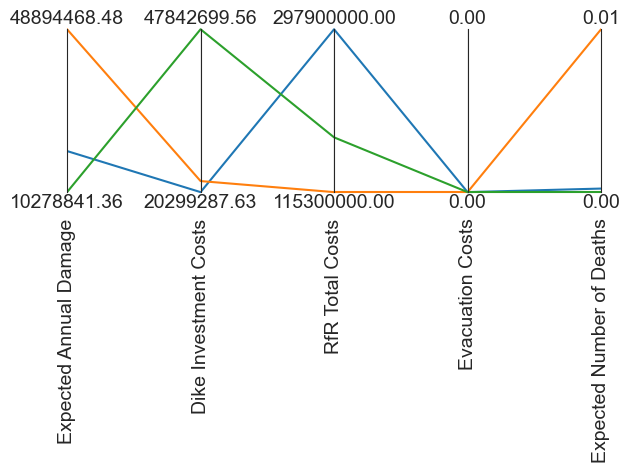

In [7]:
data = results1.loc[:, [o.name for o in dike_model.outcomes]]
limits = parcoords.get_limits(data)

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

In [8]:
# Get the lever names from your model
lever_names = [lever.name for lever in dike_model.levers]

# Extract only the levers (i.e., policies) into a new DataFrame
policies_df = results1[lever_names]

pd.set_option('display.max_columns', 50)
policies_df.head()

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,3_RfR 1,3_RfR 2,4_RfR 0,4_RfR 1,4_RfR 2,EWS_DaysToThreat,A.1_DikeIncrease 0,A.1_DikeIncrease 1,A.1_DikeIncrease 2,A.2_DikeIncrease 0,A.2_DikeIncrease 1,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
0,0,0,1,0,0,0,1,1,1,0,0,1,0,0,0,3,0,0,0,0,0,0,1,0,0,6,7,7,5,4,5
1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,3,0,0,0,0,0,0,2,0,0,6,2,3,4,7,6
2,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,3,0,0,0,3,0,0,0,0,0,9,3,2,6,7,5


In [ ]:
fig, ax = plt.subplots(ncols=1, sharex=True, figsize=(8,4))
ax.plot(convergence.nfe, convergence.epsilon_progress)
ax.set_ylabel('$\epsilon$-progress')
ax.set_xlabel('number of function evaluations reference scenario')
plt.show